Installation of Libraries

In [2]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install nltk
!pip install matplotlib
!pip install wordcloud
!pip install scikit-learn
!pip install tensorflow

Loading the Datasets and Printing of dataset

In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset into a pandas DataFrame
df = pd.read_csv('emotion_text.csv')

# Display the first few rows of the dataset
print(df.head())

# Proceed with your analysis and machine learning tasks


     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


Train, Test and Validation Dataset

In [4]:
# Modified load_dataset function using pandas
def load_dataset(filepath):
    # Using pandas to read the file with ';' as the delimiter
    return pd.read_csv(filepath, delimiter=';', header=None, names=["text", "emotion"])

# Example usage:
train_data = load_dataset("/content/train.txt")
validation_data = load_dataset("/content/val.txt")
test_data = load_dataset("/content/test.txt")

# Display the first few rows of each dataset
print("Training Data:")
print(train_data.head())

print("\nValidation Data:")
print(validation_data.head())

print("\nTest Data:")
print(test_data.head())


Training Data:
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Validation Data:
                                                text  emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3                  i am just feeling cranky and blue    anger
4  i can have for a treat or if i am feeling festive      joy

Test Data:
                                                text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separ

Combining Train, Test and Validation dataset

In [5]:
df = pd.concat([train_data, validation_data, test_data])
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
df.shape

(20000, 2)

Data Preprocessing

In [7]:
# Import necessary libraries for text processing
import nltk
import re
import string

# Download NLTK data resources
nltk.download('stopwords')
nltk.download('wordnet')  # Required for lemmatization
nltk.download('omw-1.4')  # WordNet lemmatizer updates

# Initialize text processing tools
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.snowball.SnowballStemmer("english")

# Additional preprocessing functions
def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove special characters and numbers (keep only alphabets and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Tokenize text
    tokens = text.split()

    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    # 6. Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 7. Optionally, apply stemming (uncomment if required)
    # tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    return processed_text

# Example of applying this to a DataFrame (assuming df is your DataFrame with a 'text' column)
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display the cleaned data
print(df[['text', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                        cleaned_text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  


Exploratory Data Analysis

In [8]:
df.isnull().sum()

,0
text,0
emotion,0
cleaned_text,0


In [9]:
df.duplicated().sum()

1

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          19999 non-null  object
 1   emotion       19999 non-null  object
 2   cleaned_text  19999 non-null  object
dtypes: object(3)
memory usage: 625.0+ KB


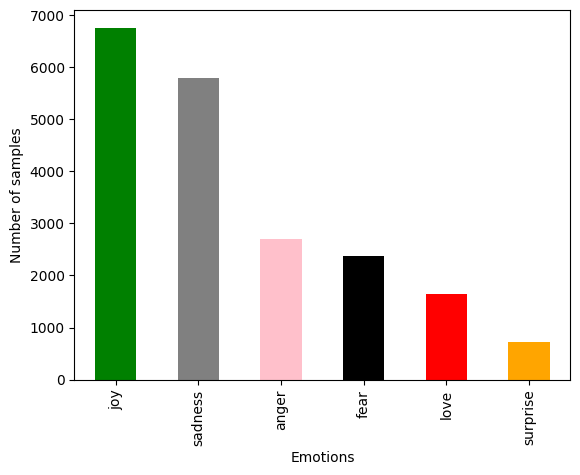

In [12]:
df['emotion'].value_counts().plot(kind='bar', color=['green', 'gray', 'pink', 'black', 'red', 'orange'])
plt.xlabel('Emotions')
plt.ylabel('Number of samples')
plt.show()

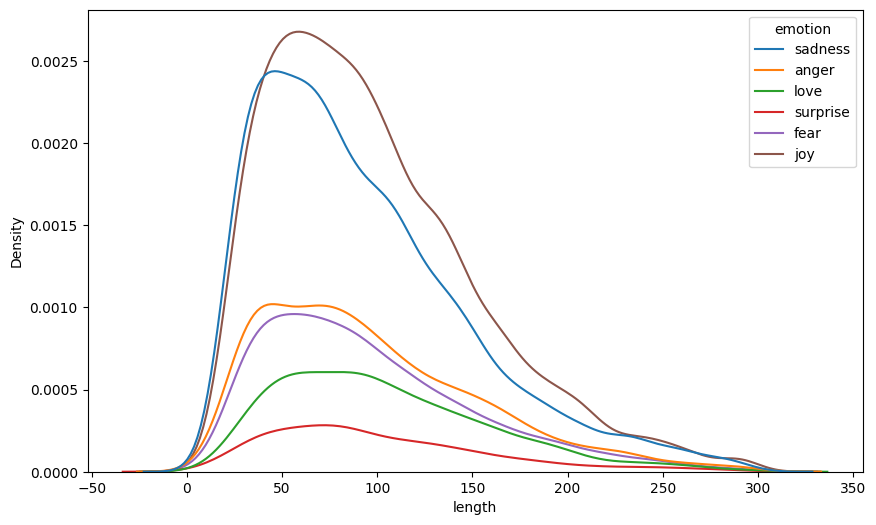

In [13]:
df['length'] = df.text.apply(lambda x:len(x))
fig = plt.figure(figsize=(10,6))
sns.kdeplot(x=df['length'], hue=df["emotion"])
plt.show()

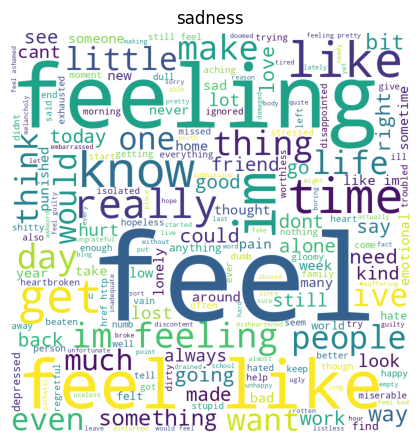

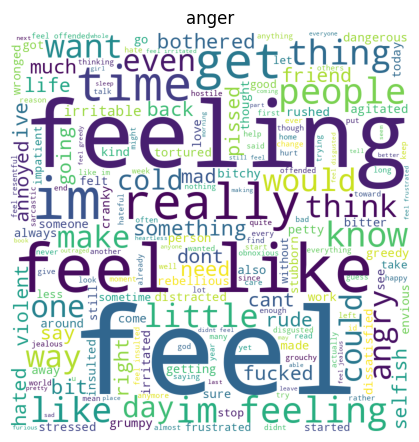

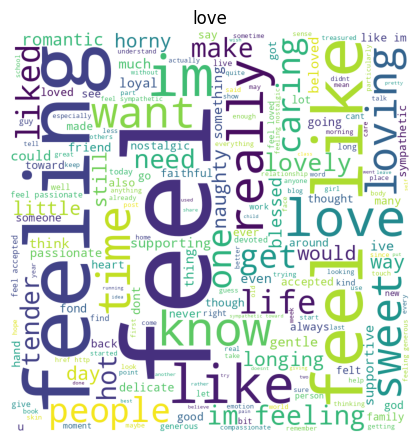

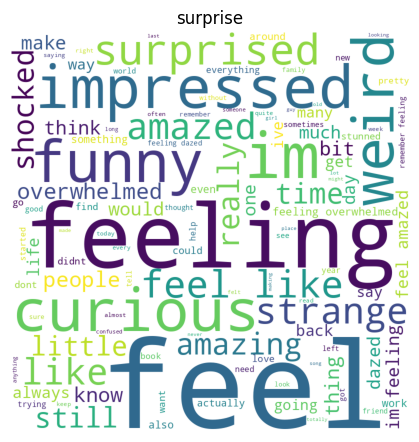

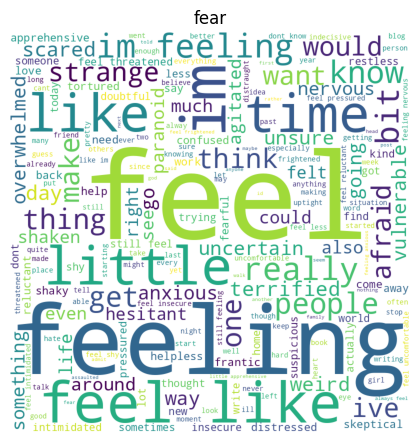

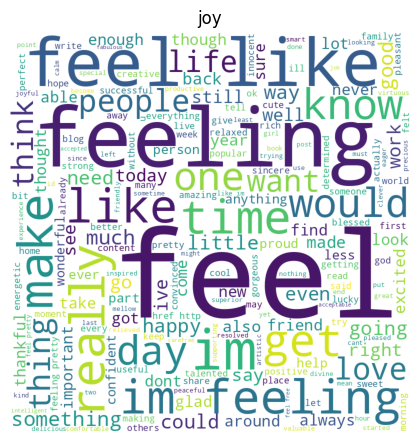

In [14]:
emotions = df['emotion'].unique()
for emotion in emotions:
    text = " ".join(df[df['emotion'] == emotion]['text'])
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(text)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(emotion)
    plt.show()

Training data and Testing data split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["emotion"], test_size=0.2, random_state=42)

**Modeling**

In [16]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

**Logistic** **Regression**

In [17]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=100)
log_reg.fit(X_train_cv, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test_cv)

# Classification report
report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Classification report of Logistic Regression:\n", report_log_reg)

# Accuracy score
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Accuracy of Logistic Regression:", accuracy_log_reg)


Classification report of Logistic Regression:
               precision    recall  f1-score   support

       anger       0.91      0.88      0.89       537
        fear       0.83      0.83      0.83       441
         joy       0.91      0.94      0.92      1334
        love       0.84      0.79      0.82       330
     sadness       0.93      0.94      0.94      1203
    surprise       0.81      0.70      0.75       155

    accuracy                           0.90      4000
   macro avg       0.87      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000

Accuracy of Logistic Regression: 0.89925


**Multinomial** **Naive** **Bayes**

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Train Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train_cv, y_train)

# Make predictions
y_pred_mnb = mnb.predict(X_test_cv)

# Classification report
report_mnb = classification_report(y_test, y_pred_mnb)
print("Classification report of Multinomial Naive Bayes:\n", report_mnb)

# Accuracy score
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print("Accuracy of Multinomial Naive Bayes:", accuracy_mnb)



Classification report of Multinomial Naive Bayes:
               precision    recall  f1-score   support

       anger       0.91      0.61      0.73       537
        fear       0.84      0.51      0.64       441
         joy       0.72      0.96      0.82      1334
        love       0.92      0.25      0.39       330
     sadness       0.75      0.93      0.83      1203
    surprise       1.00      0.02      0.04       155

    accuracy                           0.76      4000
   macro avg       0.86      0.55      0.57      4000
weighted avg       0.79      0.76      0.73      4000

Accuracy of Multinomial Naive Bayes: 0.76075


**LSTM**

In [21]:
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame with 'text' and 'emotion' columns
X = df['text']
y = df['emotion']

# Encode the labels (emotions)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # This will give you the labels as [0, 1, 2, 3, 4, 5]
emotions = le.classes_  # This will give you the original emotion names

# Tokenize and pad the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_len = 100  # Adjust as necessary
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Split the data
from sklearn.model_selection import train_test_split
X_train_pad, X_test_pad, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(len(emotions), activation='softmax'))  # Multi-class output layer

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on test data
y_pred_probs = model.predict(X_test_pad)
y_pred_lstm = y_pred_probs.argmax(axis=1)  # Get the index of the highest probability

# Classification report for LSTM
report_lstm = classification_report(y_test, y_pred_lstm, target_names=emotions)
print("Classification report of LSTM:\n", report_lstm)

# Accuracy score
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("Accuracy of LSTM:", accuracy_lstm)


Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 91s 217ms/step - accuracy: 0.4065 - loss: 1.4975 - val_accuracy: 0.7547 - val_loss: 0.6950
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 142s 218ms/step - accuracy: 0.8555 - loss: 0.4678 - val_accuracy: 0.8959 - val_loss: 0.3139
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 224ms/step - accuracy: 0.9570 - loss: 0.1400 - val_accuracy: 0.9122 - val_loss: 0.2884
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 140s 218ms/step - accuracy: 0.9762 - loss: 0.0779 - val_accuracy: 0.9072 - val_loss: 0.2803
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 146s 229ms/step - accuracy: 0.9799 - loss: 0.0647 - val_accuracy: 0.9062 - val_loss: 0.3221
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 87s 219ms/step - accuracy: 0.9851 - loss: 0.0467 - val_accuracy: 0.9212 - val_loss: 0.2724
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 141s 217ms/step - accuracy: 0.9885 - loss: 0.0346 - val_accuracy: 0.9109 - val_loss: 0.3771
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 91s 227ms/step - accuracy: 0.9882 - los

**Model** **Ensembling**



In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Assuming y_pred_log_reg and y_pred_mnb are the predictions from the respective models
# Ensure LSTM predictions are converted from probabilities to class labels
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype("int32").flatten()  # Flatten to ensure it's a 1D array

# Convert the predictions from logistic regression and multinomial naive bayes to their integer labels
# Ensure that you have already transformed your labels using LabelEncoder
y_pred_log_reg_int = le.transform(y_pred_log_reg)  # Transform if still in string format
y_pred_mnb_int = le.transform(y_pred_mnb)  # Transform if still in string format

# Stack the predictions to form a 2D array
predictions = np.array([y_pred_log_reg_int, y_pred_mnb_int, y_pred_lstm_classes], dtype=int)  # Ensure int type

# Perform majority voting
# This works by taking the mode across the predictions
ensemble_predictions = np.array([np.bincount(pred).argmax() for pred in predictions.T])

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Accuracy of Ensemble Model: {:.2f}".format(ensemble_accuracy))

# Generate classification report for ensemble model
report_ensemble = classification_report(y_test, ensemble_predictions, target_names=emotions)
print("Classification report of Ensemble Model:\n", report_ensemble)


Accuracy of Ensemble Model: 0.82
Classification report of Ensemble Model:
               precision    recall  f1-score   support

       anger       0.90      0.90      0.90       537
        fear       0.44      0.88      0.58       441
         joy       0.92      0.92      0.92      1334
        love       0.93      0.24      0.38       330
     sadness       0.94      0.90      0.92      1203
    surprise       1.00      0.02      0.04       155

    accuracy                           0.82      4000
   macro avg       0.85      0.64      0.62      4000
weighted avg       0.87      0.82      0.80      4000

